In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Import và Setup

In [12]:
import os
from pathlib import Path

import cv2
import numpy as np

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

print("✅ Libraries imported.")

✅ Libraries imported.


# Path

In [13]:
BASE_DIR = "flowers"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

base_dir = Path(BASE_DIR)
train_dir = Path(TRAIN_DIR)
val_dir   = Path(VAL_DIR)
test_dir  = Path(TEST_DIR)

class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
print("Classes:", class_names)

Classes: ['daisy', 'dandelion', 'lily', 'orchid', 'rose', 'sunflower', 'tulip']


# Trích HSV histogram

In [14]:
def extract_hsv_hist(img_bgr, bins=(4,4,4)):
    """
    HSV 3D histogram (ít bins để tránh quá dài).
    Hellinger normalization (L1 + sqrt).
    """
    img_resized = cv2.resize(img_bgr, (256, 256))
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)

    hist = cv2.calcHist(
        [hsv], [0,1,2], None,
        bins,                       # (H,S,V)
        [0,180, 0,256, 0,256]
    )
    hist = hist.astype("float32")
    hist = hist.flatten()

    # Hellinger cho màu
    hist /= (hist.sum() + 1e-7)
    hist = np.sqrt(hist)
    return hist


def extract_center_hsv_hist(img_bgr, bins=(4,4,4)):
    """
    Trích xuất HSV histogram từ vùng trung tâm ảnh.
    """
    h, w = img_bgr.shape[:2]
    # Cắt ô giữa ảnh (1/2 chiều cao, 1/2 chiều rộng)
    x1, x2 = w//4, 3*w//4
    y1, y2 = h//4, 3*h//4
    center = img_bgr[y1:y2, x1:x2]

    hsv = cv2.cvtColor(center, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv],[0,1,2],None,bins,[0,180,0,256,0,256])
    hist = hist.astype("float32").flatten()
    hist /= (hist.sum() + 1e-7)
    hist = np.sqrt(hist)   # Hellinger
    return hist


def image_to_hsv_features(img_path):
    """
    Trả về feature vector = [global_HSV_hist, center_HSV_hist]
    """
    img = cv2.imread(str(img_path))
    if img is None:
        # fallback vector zeros
        return np.zeros((4*4*4)*2, dtype=np.float32)

    img_resized = cv2.resize(img, (256, 256))

    # --- Global HSV histogram ---
    global_hsv = extract_hsv_hist(img_resized, bins=(4,4,4))  # 64 dims
    
    # --- Center HSV histogram ---
    center_hsv = extract_center_hsv_hist(img_resized, bins=(4,4,4))  # 64 dims
    
    # --- Gộp ---
    feat = np.hstack([global_hsv, center_hsv])
    return feat

# Load dataset (train / val / test)

In [15]:
def load_hsv_dataset(folder):
    """
    Load dataset với chỉ HSV features.
    """
    X, y = [], []
    folder = Path(folder)

    for label, cls in enumerate(class_names):
        cls_dir = folder / cls
        img_files = []
        for ext in ("*.jpg", "*.jpeg", "*.png"):
            img_files.extend(cls_dir.glob(ext))

        print(f"[Load] {folder.name} - {cls}: {len(img_files)} images")

        for img_path in img_files:
            feat = image_to_hsv_features(img_path)
            X.append(feat)
            y.append(label)

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)


print("\n" + "="*50)
print("Loading datasets...")
print("="*50)

X_train, y_train = load_hsv_dataset(train_dir)
X_val,   y_val   = load_hsv_dataset(val_dir)
X_test,  y_test  = load_hsv_dataset(test_dir)

print("\nDataset shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)


Loading datasets...
[Load] train - daisy: 1231 images
[Load] train - dandelion: 1046 images
[Load] train - lily: 1132 images
[Load] train - orchid: 1295 images
[Load] train - rose: 1042 images
[Load] train - sunflower: 1199 images
[Load] train - tulip: 1124 images
[Load] val - daisy: 352 images
[Load] val - dandelion: 299 images
[Load] val - lily: 324 images
[Load] val - orchid: 370 images
[Load] val - rose: 298 images
[Load] val - sunflower: 342 images
[Load] val - tulip: 321 images
[Load] test - daisy: 176 images
[Load] test - dandelion: 150 images
[Load] test - lily: 162 images
[Load] test - orchid: 186 images
[Load] test - rose: 149 images
[Load] test - sunflower: 172 images
[Load] test - tulip: 161 images

Dataset shapes:
Train: (8069, 128) (8069,)
Val  : (2306, 128) (2306,)
Test : (1156, 128) (1156,)


# Chuẩn hóa + PCA

In [16]:
print("\n" + "="*50)
print("Standardizing features...")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Applying PCA...")
pca = PCA(n_components=0.95, random_state=42)  # Giảm từ 128 xuống 64
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca   = pca.transform(X_val_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print("Original dim:", X_train_scaled.shape[1])
print("After PCA   :", X_train_pca.shape[1])


Standardizing features...
Applying PCA...
Original dim: 128
After PCA   : 69


# Train SVM

In [17]:
best_params = {"C": 10, "gamma": "scale", "kernel": "rbf"}

print("\n" + "="*50)
print("TRAINING SVM (HSV only)")
print("="*50)
print(f"Using hyperparameters: {best_params}")

# 1. Khởi tạo và Train trên tập Train
clf = SVC(
    C=best_params["C"], 
    gamma=best_params["gamma"], 
    kernel=best_params["kernel"], 
    random_state=42
)
clf.fit(X_train_pca, y_train)

# 2. Đánh giá sơ bộ trên Validation
val_pred = clf.predict(X_val_pca)
val_acc = accuracy_score(y_val, val_pred)
print(f"✅ Phase 1 Done.")
print(f"Validation Accuracy: {val_acc:.4f}")

# ============================================
#  Train lại trên Train+Val với best params
# ============================================

print("\n" + "="*50)
print("Train lại trên Train+Val với best params")
print("="*50)

# 1. Gộp dữ liệu Train và Val (dữ liệu GỐC chưa scale)
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

# 2. FIT LẠI Scaler và PCA từ đầu trên tập gộp
# (Lý do: scaler/pca cũ chỉ học trên Train, giờ ta có nhiều dữ liệu hơn nên học lại sẽ tốt hơn)
scaler_final = StandardScaler()
X_train_full_scaled = scaler_final.fit_transform(X_train_full)

pca_final = PCA(n_components=0.95, random_state=42)
X_train_full_pca = pca_final.fit_transform(X_train_full_scaled)

# 3. Transform tập Test theo Scaler/PCA mới
X_test_scaled = scaler_final.transform(X_test)
X_test_pca = pca_final.transform(X_test_scaled)

# 4. Huấn luyện model cuối cùng
svm_final = SVC(
    C=best_params["C"], 
    gamma=best_params["gamma"], 
    kernel=best_params["kernel"], 
    random_state=42, 
    probability=True
)
svm_final.fit(X_train_full_pca, y_train_full)
print("✅ Final model trained successfully.")


TRAINING SVM (HSV only)
Using hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
✅ Phase 1 Done.
Validation Accuracy: 0.8005

Train lại trên Train+Val với best params
✅ Final model trained successfully.


# Đánh giá


ĐÁNH GIÁ TRÊN TEST SET
Test accuracy: 0.7975778546712803

Classification report:
              precision    recall  f1-score   support

       daisy     0.8497    0.8352    0.8424       176
   dandelion     0.8411    0.8467    0.8439       150
        lily     0.7181    0.8333    0.7714       162
      orchid     0.7833    0.7581    0.7705       186
        rose     0.7045    0.6242    0.6619       149
   sunflower     0.8913    0.9535    0.9213       172
       tulip     0.7770    0.7143    0.7443       161

    accuracy                         0.7976      1156
   macro avg     0.7950    0.7950    0.7937      1156
weighted avg     0.7968    0.7976    0.7959      1156



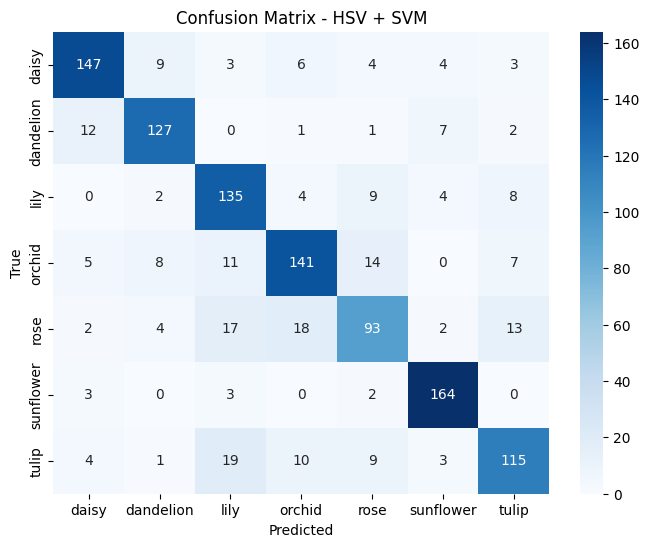

In [18]:
test_pred = svm_final.predict(X_test_pca)
test_acc = accuracy_score(y_test, test_pred)

print("\n" + "="*50)
print("ĐÁNH GIÁ TRÊN TEST SET")
print("="*50)
print("Test accuracy:", test_acc)
print("\nClassification report:")
print(classification_report(y_test, test_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HSV + SVM")
plt.show()


Finding correct and incorrect predictions...
Total correct: 712
Total incorrect: 444

3 ẢNH DỰ ĐOÁN ĐÚNG


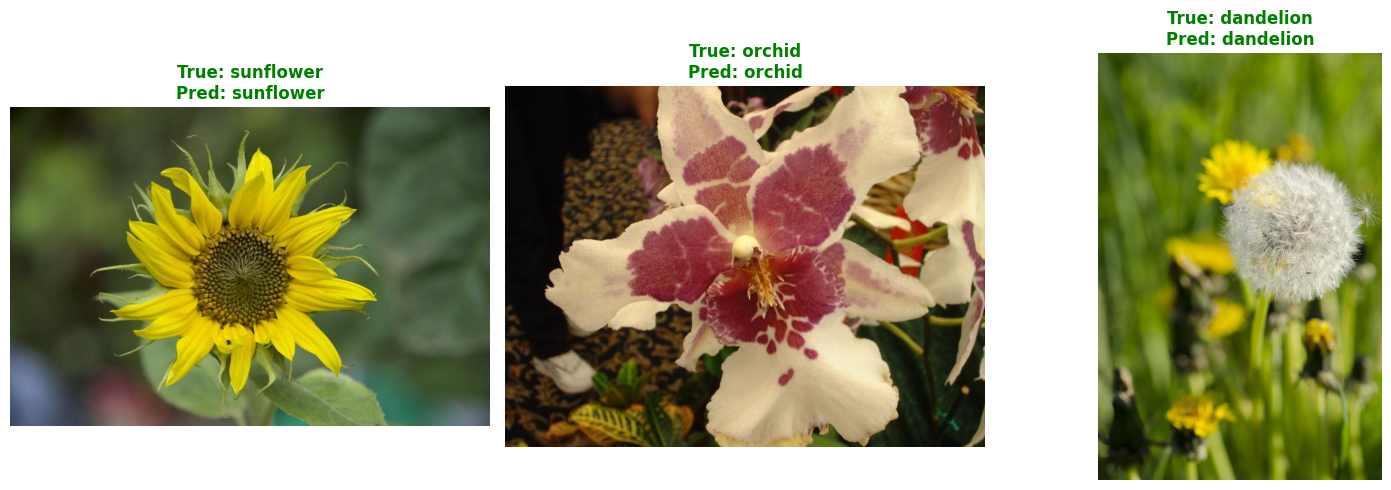


3 ẢNH DỰ ĐOÁN SAI


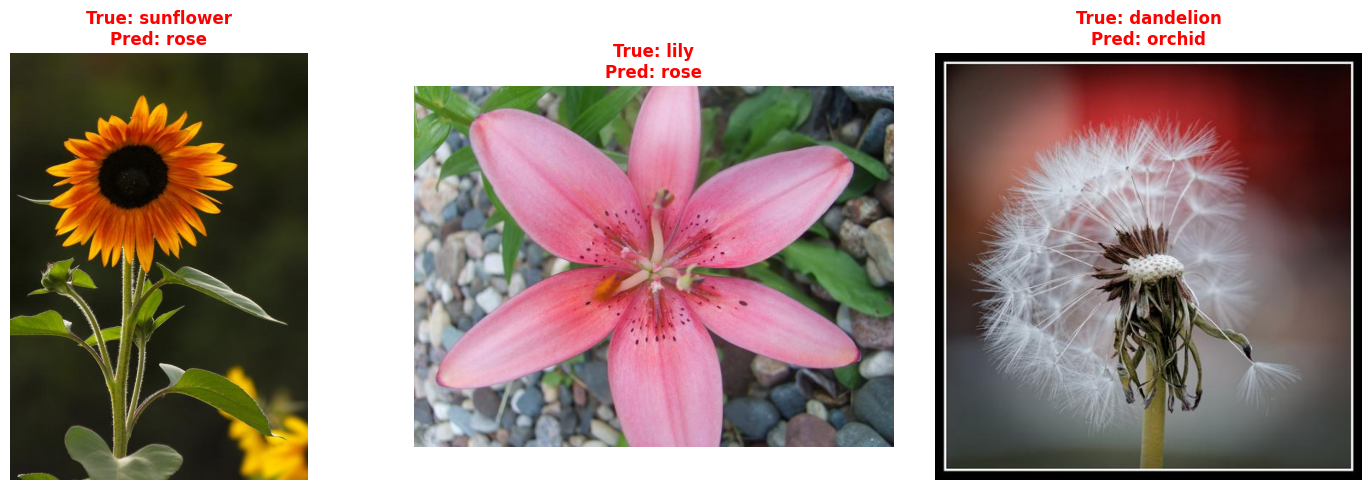

In [19]:

print("\n" + "="*50)
print("Finding correct and incorrect predictions...")
print("="*50)

# Lấy danh sách tất cả ảnh test
test_images = []
for label, cls in enumerate(class_names):
    cls_dir = test_dir / cls
    img_files = []
    for ext in ("*.jpg", "*.jpeg", "*.png"):
        img_files.extend(cls_dir.glob(ext))
    
    for img_path in img_files:
        test_images.append((img_path, label))

# Dự đoán và phân loại
correct_predictions = []
incorrect_predictions = []

for img_path, true_label in test_images:
    feats = image_to_hsv_features(img_path)
    feats = feats.reshape(1, -1)
    feats_scaled = scaler.transform(feats)
    feats_pca = pca.transform(feats_scaled)
    pred_label = svm_final.predict(feats_pca)[0]
    
    if pred_label == true_label:
        correct_predictions.append((img_path, true_label, pred_label))
    else:
        incorrect_predictions.append((img_path, true_label, pred_label))

print(f"Total correct: {len(correct_predictions)}")
print(f"Total incorrect: {len(incorrect_predictions)}")

# Hiển thị 3 ảnh dự đoán đúng
if len(correct_predictions) >= 3:
    print("\n" + "="*50)
    print("3 ẢNH DỰ ĐOÁN ĐÚNG")
    print("="*50)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    np.random.seed(42)
    sample_correct = np.random.choice(len(correct_predictions), 3, replace=False)
    
    for idx, sample_idx in enumerate(sample_correct):
        img_path, true_label, pred_label = correct_predictions[sample_idx]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
                           color='green', fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Hiển thị 3 ảnh dự đoán sai
if len(incorrect_predictions) >= 3:
    print("\n" + "="*50)
    print("3 ẢNH DỰ ĐOÁN SAI")
    print("="*50)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    np.random.seed(42)
    sample_incorrect = np.random.choice(len(incorrect_predictions), 3, replace=False)
    
    for idx, sample_idx in enumerate(sample_incorrect):
        img_path, true_label, pred_label = incorrect_predictions[sample_idx]
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(img_rgb)
        axes[idx].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", 
                           color='red', fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Lưu file model

In [20]:
model_data = {
    "scaler": scaler,           # Để chuẩn hóa dữ liệu
    "pca": pca,                 # Để giảm chiều dữ liệu
    "model": svm_final,         # Model SVM cuối cùng
    "class_names": class_names, # Danh sách tên các loài hoa
}

filename = "hsv_only_svm.pkl"
with open(filename, "wb") as f:
    pickle.dump(model_data, f)

print("\n" + "="*50)
print(f"✅ Đã lưu xong file: {filename}")
print("="*50)


✅ Đã lưu xong file: hsv_only_svm.pkl
